Model LSTM

In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load the data
data = pd.read_csv('mfcc.csv')

Processing

In [3]:
# Normalize MFCC features
scaler = StandardScaler()
mfcc_features = data.iloc[:, 1:-1].values  # Extract MFCC features
scaled_features = scaler.fit_transform(mfcc_features)

In [4]:
# Save the scaler parameters
np.save('scaler_mean.npy', scaler.mean_)
np.save('scaler_scale.npy', scaler.scale_)

In [5]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['label'].values)

# Convert to tensors
features_tensor = torch.tensor(scaled_features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

In [6]:
# Prepare Dataset and DataLoader
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create dataset
dataset = AudioDataset(features_tensor, labels_tensor)

Model LSTM

In [7]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))  # Adding an extra dimension for sequence_length
        out = self.fc(out[:, -1, :])
        return out

In [8]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Hyperparameters
input_size = scaled_features.shape[1]  # Number of MFCC features
num_classes = len(label_encoder.classes_)
learning_rate = 0.001
batch_size = 32
num_epochs = 20

# Hyperparameter grid
hidden_sizes = [64, 128]
num_layers_list = [1, 2]

K-Fold Cross-Validation

In [22]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

def train_and_evaluate_model(hidden_size, num_layers):
    accuracies = []
    all_labels = []
    all_predictions = []
    
    for train_index, val_index in skf.split(features_tensor, labels_tensor):
        train_subset = torch.utils.data.Subset(dataset, train_index)
        val_subset = torch.utils.data.Subset(dataset, val_index)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        accuracy = correct / total
        accuracies.append(accuracy)
    
    return np.mean(accuracies), all_labels, all_predictions

Train First

In [33]:
# Perform hyperparameter tuning
best_accuracy = 0
best_params = {}

for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        accuracy, all_labels, all_predictions = train_and_evaluate_model(hidden_size, num_layers)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'hidden_size': hidden_size, 'num_layers': num_layers}
            best_labels = all_labels
            best_predictions = all_predictions
print(f'Best Hyperparameters: {best_params}')
print(f'Best Accuracy: {best_accuracy:.4f}')

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 2}
Best Accuracy: 0.9709


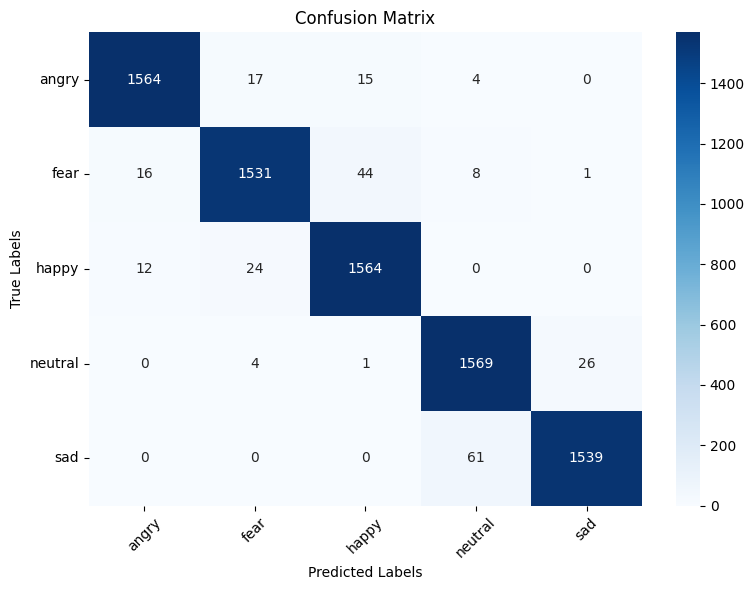

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(best_labels, best_predictions)
classes = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:

# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(best_labels, best_predictions))
print("Classification Report:")
print(classification_report(best_labels, best_predictions, target_names=label_encoder.classes_))

Confusion Matrix:
[[1564   17   15    4    0]
 [  16 1531   44    8    1]
 [  12   24 1564    0    0]
 [   0    4    1 1569   26]
 [   0    0    0   61 1539]]
Classification Report:
              precision    recall  f1-score   support

       angry       0.98      0.98      0.98      1600
        fear       0.97      0.96      0.96      1600
       happy       0.96      0.98      0.97      1600
     neutral       0.96      0.98      0.97      1600
         sad       0.98      0.96      0.97      1600

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



Train final

In [43]:
# Train final model with best hyperparameters
best_hidden_size = best_params['hidden_size']
best_num_layers = best_params['num_layers']

model = LSTMModel(input_size, best_hidden_size, best_num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Save Model & Label

In [44]:
# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')
print("Model saved successfully!")

# Save label encoder classes
np.save('classes.npy', label_encoder.classes_)
print("Label encoder classes saved successfully!")

Model saved successfully!
Label encoder classes saved successfully!
